In [44]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Statistical analysis
from scipy import stats
from scipy.stats import mannwhitneyu, bootstrap

# Set styling for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 3)

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All dependencies loaded successfully")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")

✓ All dependencies loaded successfully
  pandas: 2.3.3
  numpy: 2.4.1


In [45]:
# Load data
df = pd.read_csv('../outputs/preprocessed.csv')

print(f"Total rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(f"\nSample of dataset_name and dataset_size:")
print(df[['dataset_name', 'dataset_size']].drop_duplicates().sort_values('dataset_name'))
print(f"\nDataset size statistics:")
print(df['dataset_size'].describe())
print(f"\nFirst few rows:")
df.head(5)

Total rows: 840
Columns: 33

Sample of dataset_name and dataset_size:
                             dataset_name  dataset_size
281         3D Dense Clusters (1K points)          1000
0           Iris Dataset (150 points, 4D)           150
280          MNIST-like (1K points, 784D)          1000
141         Medium Clustered (600 points)           600
1                Small Random (80 points)            80
140  Swiss Roll (600 points, 3D manifold)           600

Dataset size statistics:
count     840.000
mean      571.667
std       362.634
min        80.000
25%       150.000
50%       600.000
75%      1000.000
max      1000.000
Name: dataset_size, dtype: float64

First few rows:


,generated_at,runs_declared,result_run,result_duration_ms,stats_start_time,stats_duration_ms,wasm_features_file,wasm_preload,machine_platform,machine_release,machine_arch,cpu_model,cpu_cores,total_mem_bytes,load_avg_1,load_avg_5,load_avg_15,hostname,git_commit,git_branch,git_status_dirty,dataset_index,timestamp,dataset_name,dataset_size,dimensions,wasm_features,rendering_enabled,runtime_ms,memory_delta_mb,trustworthiness,fps_avg,responsiveness_ms
0,2026-02-06T11:20:33.775Z,10,1,42009,2026-02-06T11:20:49.897Z,26357.105,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,1,2026-02-06T11:21:09.350Z,"Iris Dataset (150 points, 4D)",150,4,none,False,2395.8,3.004,0.986,60.000,9.791
1,2026-02-06T11:20:33.775Z,10,1,42009,2026-02-06T11:20:49.897Z,26357.105,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,2,2026-02-06T11:21:15.865Z,Small Random (80 points),80,10,none,False,3271.7,8.117,0.880,49.222,21.187
2,2026-02-06T11:20:33.775Z,10,2,41022,2026-02-06T11:21:30.915Z,27077.329,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,1,2026-02-06T11:21:50.238Z,"Iris Dataset (150 points, 4D)",150,4,none,False,2388.4,1.363,0.989,59.994,9.682
3,2026-02-06T11:20:33.775Z,10,2,41022,2026-02-06T11:21:30.915Z,27077.329,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,2,2026-02-06T11:21:56.264Z,Small Random (80 points),80,10,none,False,3538.4,8.718,0.868,46.995,23.280
4,2026-02-06T11:20:33.775Z,10,3,39489,2026-02-06T11:22:12.441Z,25040.741,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,1,2026-02-06T11:22:30.309Z,"Iris Dataset (150 points, 4D)",150,4,none,False,2375.8,0.014,0.989,59.994,8.155


In [46]:
# Standardize column names and prepare data
df_clean = df.copy()

# Create standardized feature column
# Handle comma-separated features (all features combined) and convert to lowercase
df_clean['feature'] = df_clean['wasm_features'].fillna('none').str.lower().str.strip()

# Map comma-separated features to 'all'
df_clean.loc[df_clean['feature'].str.contains(',', na=False), 'feature'] = 'all'

# Standardize feature names
feature_map = {
    'none': 'Baseline (JS)',
    'dist': 'Distance',
    'tree': 'Tree',
    'matrix': 'Matrix',
    'nn': 'NN Descent',
    'opt': 'Optimizer',
    'all': 'All Features'
}
df_clean['feature_name'] = df_clean['feature'].map(feature_map)

# Normalize rendering_enabled from data
# Accepts booleans, 0/1, or common strings
df_clean['rendering_enabled'] = (
    df_clean['rendering_enabled']
    .astype(str)
    .str.lower()
    .map({'true': True, 'false': False, '1': True, '0': False, 'yes': True, 'no': False})
)

# Convert numeric columns
numeric_cols = ['runtime_ms', 'memory_delta_mb', 'trustworthiness', 'fps_avg', 'responsiveness_ms']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Remove missing values in key columns
df_clean = df_clean.dropna(subset=['runtime_ms', 'feature_name'])

print(f"\nAfter cleaning: {len(df_clean):,} rows")
print(f"\nFeature distribution:")
print(df_clean['feature_name'].value_counts().sort_index())
print(f"\nRendering enabled distribution:")
print(df_clean['rendering_enabled'].value_counts(dropna=False))
print(f"\nDataset distribution:")
print(df_clean['dataset_name'].value_counts())



After cleaning: 840 rows

Feature distribution:
feature_name
All Features     120
Baseline (JS)    120
Distance         120
Matrix           120
NN Descent       120
Optimizer        120
Tree             120
Name: count, dtype: int64

Rendering enabled distribution:
rendering_enabled
False    460
True     380
Name: count, dtype: int64

Dataset distribution:
dataset_name
Iris Dataset (150 points, 4D)           140
Small Random (80 points)                140
Swiss Roll (600 points, 3D manifold)    140
Medium Clustered (600 points)           140
MNIST-like (1K points, 784D)            140
3D Dense Clusters (1K points)           140
Name: count, dtype: int64


Baseline (JS) runs: 120
  With rendering: 60
  Without rendering: 60

Metrics to plot: ['Runtime (ms)', 'Memory Delta (MB)', 'Average FPS', 'Responsiveness (ms)', 'Trustworthiness']


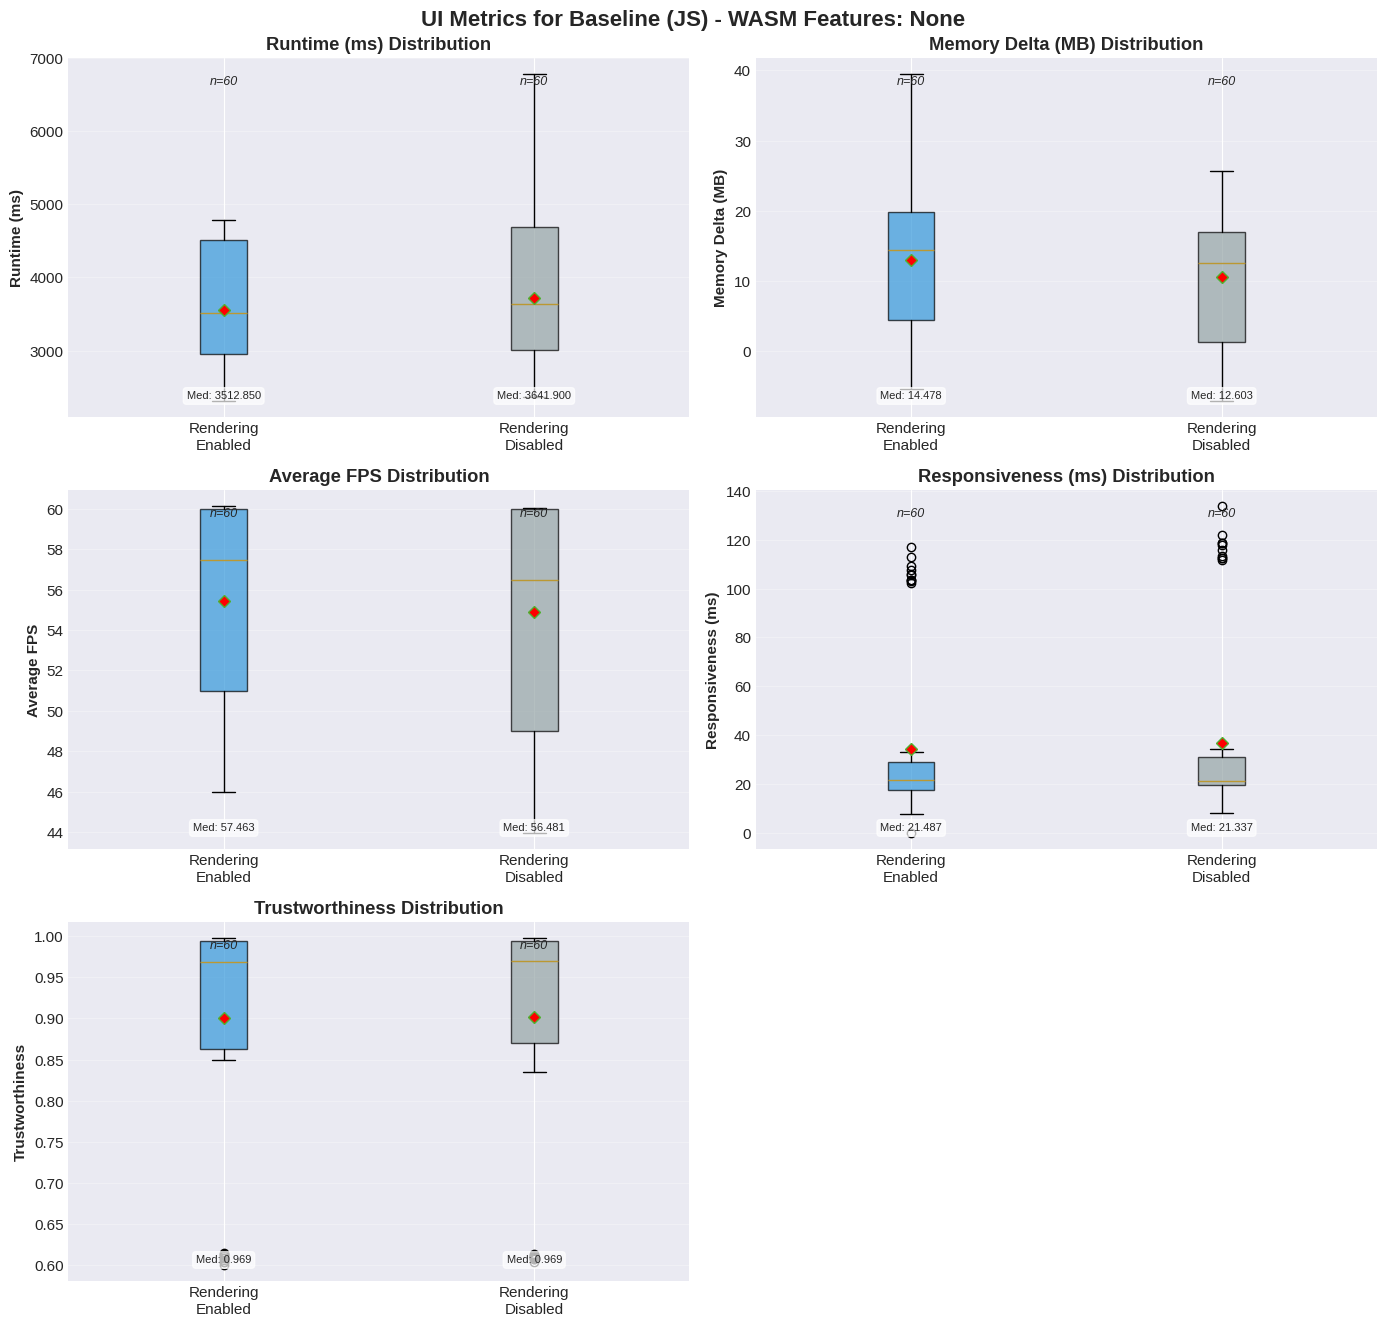


SUMMARY STATISTICS - Baseline (JS) with WASM Features: None

Runtime (ms):
------------------------------------------------------------
  Rendering Enabled:
    Mean: 3552.0033, Median: 3512.8500, Std: 827.6343
    Min: 2316.5000, Max: 4790.0000
  Rendering Disabled:
    Mean: 3717.2133, Median: 3641.9000, Std: 978.3729
    Min: 2368.3000, Max: 6777.8000
  Mann-Whitney U test: p-value = 0.088534 (n.s.)

Memory Delta (MB):
------------------------------------------------------------
  Rendering Enabled:
    Mean: 13.0023, Median: 14.4784, Std: 9.4516
    Min: -5.3105, Max: 39.4664
  Rendering Disabled:
    Mean: 10.5684, Median: 12.6026, Std: 8.6458
    Min: -6.9974, Max: 25.6957
  Mann-Whitney U test: p-value = 0.151144 (n.s.)

Average FPS:
------------------------------------------------------------
  Rendering Enabled:
    Mean: 55.4251, Median: 57.4631, Std: 4.9602
    Min: 45.9908, Max: 60.1400
  Rendering Disabled:
    Mean: 54.9057, Median: 56.4811, Std: 5.3844
    Min: 43.9692,

In [47]:
# Visualize UI metrics for Baseline (JS) - WASM features = None
# Separated by rendering enabled/disabled. Now includes additional metrics like trustworthiness.

# Filter for baseline (no WASM features)
df_baseline = df_clean[df_clean['feature'] == 'none'].copy()

print(f"Baseline (JS) runs: {len(df_baseline):,}")
print(f"  With rendering: {len(df_baseline[df_baseline['rendering_enabled'] == True]):,}")
print(f"  Without rendering: {len(df_baseline[df_baseline['rendering_enabled'] == False]):,}")

# Candidate metrics to visualize (will only be plotted if present and contain data)
candidate_metrics = [
    ('runtime_ms', 'Runtime (ms)'),
    ('memory_delta_mb', 'Memory Delta (MB)'),
    ('fps_avg', 'Average FPS'),
    ('responsiveness_ms', 'Responsiveness (ms)'),
    ('trustworthiness', 'Trustworthiness')
]

# Select metrics that exist in the dataframe and have at least one non-null value
metrics_to_plot = []
for col_name, label in candidate_metrics:
    if col_name in df_baseline.columns and df_baseline[col_name].dropna().shape[0] > 0:
        metrics_to_plot.append((col_name, label))

print(f"\nMetrics to plot: {[m[1] for m in metrics_to_plot]}")

if len(metrics_to_plot) == 0:
    print('No UI metrics found to plot for baseline.')
else:
    # Determine subplot grid (2 columns)
    import math
    n = len(metrics_to_plot)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 4.5 * rows))
    fig.suptitle('UI Metrics for Baseline (JS) - WASM Features: None', fontsize=16, fontweight='bold')

    # Flatten axes array for easy indexing
    if isinstance(axes, np.ndarray):
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    for idx, (metric_col, metric_label) in enumerate(metrics_to_plot):
        ax = axes_flat[idx]

        # Prepare data for plotting
        data_with_render = df_baseline[df_baseline['rendering_enabled'] == True][metric_col].dropna()
        if metric_col == 'fps_avg':
            data_with_render = data_with_render[data_with_render != 0]
        data_without_render = df_baseline[df_baseline['rendering_enabled'] == False][metric_col].dropna()
        if metric_col == 'fps_avg':
            data_without_render = data_without_render[data_without_render != 0]

        # Create box plot
        box_data = [data_with_render, data_without_render]
        box_labels = ['Rendering\nEnabled', 'Rendering\nDisabled']

        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                        showmeans=True, meanprops=dict(marker='D', markerfacecolor='red', markersize=6))

        # Color the boxes
        colors = ['#3498db', '#95a5a6']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax.set_ylabel(metric_label, fontweight='bold')
        ax.set_title(f'{metric_label} Distribution', fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        # Add sample size annotations
        ylim = ax.get_ylim()
        y_annot = ylim[1] - (ylim[1] - ylim[0]) * 0.05
        ax.text(1, y_annot, f'n={len(data_with_render)}', ha='center', va='top', fontsize=9, style='italic')
        ax.text(2, y_annot, f'n={len(data_without_render)}', ha='center', va='top', fontsize=9, style='italic')

        # Add median values as text
        if len(data_with_render) > 0:
            ax.text(1, ylim[0] + (ylim[1] - ylim[0]) * 0.05, f'Med: {data_with_render.median():.3f}',
                    ha='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        if len(data_without_render) > 0:
            ax.text(2, ylim[0] + (ylim[1] - ylim[0]) * 0.05, f'Med: {data_without_render.median():.3f}',
                    ha='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Hide any unused subplots
    for j in range(n, len(axes_flat)):
        axes_flat[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS - Baseline (JS) with WASM Features: None")
    print("="*80)

    for metric_col, metric_label in metrics_to_plot:
        print(f"\n{metric_label}:")
        print("-" * 60)

        render_data = df_baseline[df_baseline['rendering_enabled'] == True][metric_col].dropna()
        no_render_data = df_baseline[df_baseline['rendering_enabled'] == False][metric_col].dropna()

        if len(render_data) > 0:
            print(f"  Rendering Enabled:")
            print(f"    Mean: {render_data.mean():.4f}, Median: {render_data.median():.4f}, Std: {render_data.std():.4f}")
            print(f"    Min: {render_data.min():.4f}, Max: {render_data.max():.4f}")

        if len(no_render_data) > 0:
            print(f"  Rendering Disabled:")
            print(f"    Mean: {no_render_data.mean():.4f}, Median: {no_render_data.median():.4f}, Std: {no_render_data.std():.4f}")
            print(f"    Min: {no_render_data.min():.4f}, Max: {no_render_data.max():.4f}")

        # Statistical test if both groups have data
        if len(render_data) > 0 and len(no_render_data) > 0:
            stat, p_value = mannwhitneyu(render_data, no_render_data, alternative='two-sided')
            print(f"  Mann-Whitney U test: p-value = {p_value:.6f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else '(n.s.)'}")

In [48]:
# Summary table of UI metrics by dataset size (small / mid / large)
# Uses the same baseline subset and metrics chosen above.

if 'metrics_to_plot' not in globals():
    # Fallback if the previous cell wasn't run yet
    candidate_metrics = [
        ('runtime_ms', 'Runtime (ms)'),
        ('memory_delta_mb', 'Memory Delta (MB)'),
        ('fps_avg', 'Average FPS'),
        ('responsiveness_ms', 'Responsiveness (ms)'),
        ('trustworthiness', 'Trustworthiness')
    ]
    metrics_to_plot = []
    for col_name, label in candidate_metrics:
        if col_name in df_clean.columns and df_clean[col_name].dropna().shape[0] > 0:
            metrics_to_plot.append((col_name, label))

# Ensure we operate on baseline (JS)
if 'df_baseline' not in globals():
    df_baseline = df_clean[df_clean['feature'] == 'none'].copy()

metric_cols = [m[0] for m in metrics_to_plot]

# Create size buckets
labels = ['small', 'mid', 'large']
try:
    df_baseline['size_bucket'] = pd.qcut(df_baseline['dataset_size'], q=[0, 1/3, 2/3, 1], labels=labels)
except Exception:
    # Fallback to equal-width bins if qcut fails (e.g., many ties)
    df_baseline['size_bucket'] = pd.cut(df_baseline['dataset_size'], bins=3, labels=labels)

# Show thresholds for transparency
size_bounds = df_baseline.groupby('size_bucket')['dataset_size'].agg(['min','max','count']).reset_index()
print("Dataset size buckets (min/max/count):")
print(size_bounds)

# Aggregate metrics by size bucket and rendering enabled
summary = (
    df_baseline
    .groupby(['size_bucket', 'rendering_enabled'])[metric_cols]
    .agg(['mean', 'median', 'std', 'min', 'max', 'count'])
    .round(3)
)

display(summary)


Dataset size buckets (min/max/count):
  size_bucket   min   max  count
0       small    80   150     40
1         mid   600   600     40
2       large  1000  1000     40


runtime_ms                                         memory_delta_mb                 \
                                    mean   median      std     min     max count            mean  median    std   
size_bucket rendering_enabled                                                                                     
small       False                2854.88  2735.35  484.792  2368.3  3538.4    20           3.097   0.422  5.943   
            True                 2764.14  2680.45  436.058  2316.5  3413.1    20           5.517   3.030  7.316   
mid         False                3399.49  3417.40  400.170  2971.3  3849.8    20          14.620  14.719  5.992   
            True                 3325.39  3319.80  369.618  2941.7  3802.3    20          16.770  17.725  6.474   
large       False                4897.27  4777.75  471.590  4640.3  6777.8    20          13.988  15.865  8.516   
            True                 4566.48  4535.25   97.414  4438.6  4790.0    20          16.720  16.531  9.669   

                                                   fps_avg                                      responsiveness_ms  \
                                 min     max count    mean  median    std     min     max count              mean   
size_bucket rendering_enabled                                                                                       
small       False             -1.382  24.156    20  54.247  55.072  5.934  46.995  60.010    20            15.384   
            True              -1.857  27.089    20  54.010  54.594  6.193  45.991  60.039    20            14.234   
mid         False              1.110  25.091    20  56.358  56.561  3.758  51.927  60.039    20            21.002   
            True               2.688  32.004    20  56.964  57.493  3.130  52.968  60.069    20            19.946   
large       False             -6.997  25.696    20  54.112  55.046  6.111  43.969  60.028    20            73.889   
            True              -5.310  39.466    20  55.302  55.560  4.861  49.000  60.140    20            68.411   

                                                                     trustworthiness                                    
                               median     std     min      max count            mean median    std    min    max count  
size_bucket rendering_enabled                                                                                           
small       False              15.755   6.746   8.155   28.100    20           0.929  0.937  0.062  0.835  0.990    20  
            True               14.040   7.209   0.000   23.340    20           0.925  0.929  0.064  0.850  0.990    20  
mid         False              20.993   1.751  18.418   24.880    20           0.972  0.973  0.022  0.948  0.995    20  
            True               19.556   2.434  16.736   23.500    20           0.972  0.972  0.022  0.949  0.995    20  
large       False              72.887  45.226  19.547  133.745    20           0.804  0.805  0.199  0.605  0.997    20  
            True               67.631  39.804  28.467  116.882    20           0.803  0.806  0.199  0.601  0.997    20

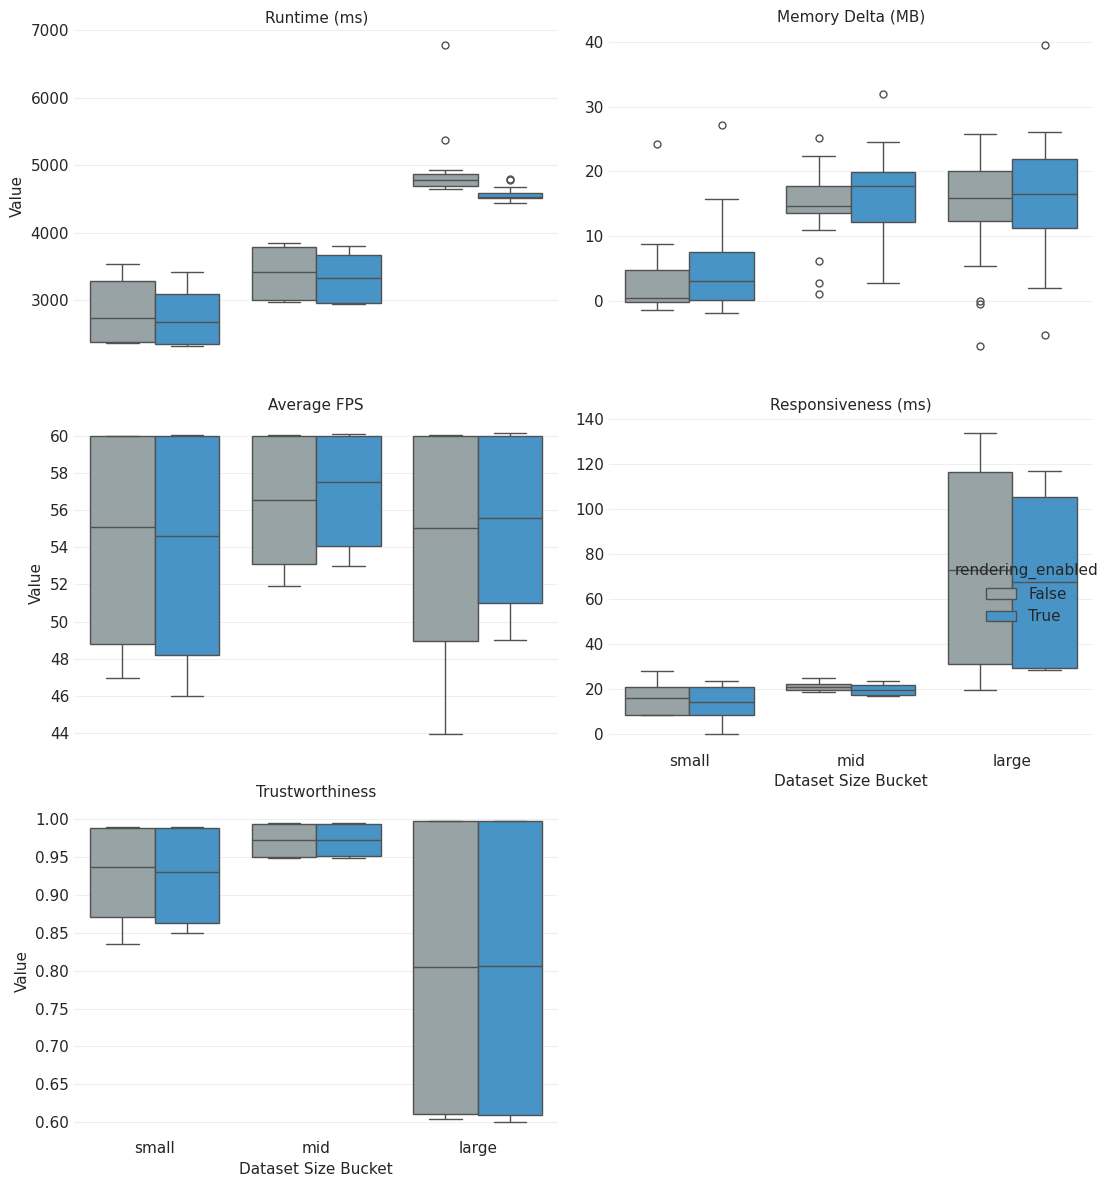

In [49]:
# Visualize UI metrics by dataset size bucket and rendering state

# Prepare long-form data
plot_df = df_baseline.copy()

# Ensure size_bucket exists
if 'size_bucket' not in plot_df.columns:
    labels = ['small', 'mid', 'large']
    try:
        plot_df['size_bucket'] = pd.qcut(plot_df['dataset_size'], q=[0, 1/3, 2/3, 1], labels=labels)
    except Exception:
        plot_df['size_bucket'] = pd.cut(plot_df['dataset_size'], bins=3, labels=labels)

metric_cols = [m[0] for m in metrics_to_plot]
metric_label_map = dict(metrics_to_plot)

long_df = plot_df.melt(
    id_vars=['size_bucket', 'rendering_enabled'],
    value_vars=metric_cols,
    var_name='metric',
    value_name='value'
)
long_df = long_df.dropna(subset=['value'])
# Exclude zero/negative FPS values from plots
long_df.loc[long_df['metric'] == 'fps_avg', 'value'] = pd.to_numeric(
    long_df.loc[long_df['metric'] == 'fps_avg', 'value'], errors='coerce'
)
long_df = long_df[~((long_df['metric'] == 'fps_avg') & (long_df['value'] <= 0))]
long_df['metric_label'] = long_df['metric'].map(metric_label_map)

# Faceted boxplots
sns.set_style('whitegrid')
g = sns.catplot(
    data=long_df,
    x='size_bucket',
    y='value',
    hue='rendering_enabled',
    col='metric_label',
    kind='box',
    col_wrap=2,
    sharey=False,
    height=4,
    aspect=1.2,
    palette={True: '#3498db', False: '#95a5a6'}
)

g.set_titles('{col_name}')
g.set_axis_labels('Dataset Size Bucket', 'Value')
for ax in g.axes.flat:
    ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


WASM-enabled runs: 720
  With rendering: 320
  Without rendering: 400
Metrics to plot: ['Runtime (ms)', 'Memory Delta (MB)', 'Average FPS', 'Responsiveness (ms)', 'Trustworthiness']


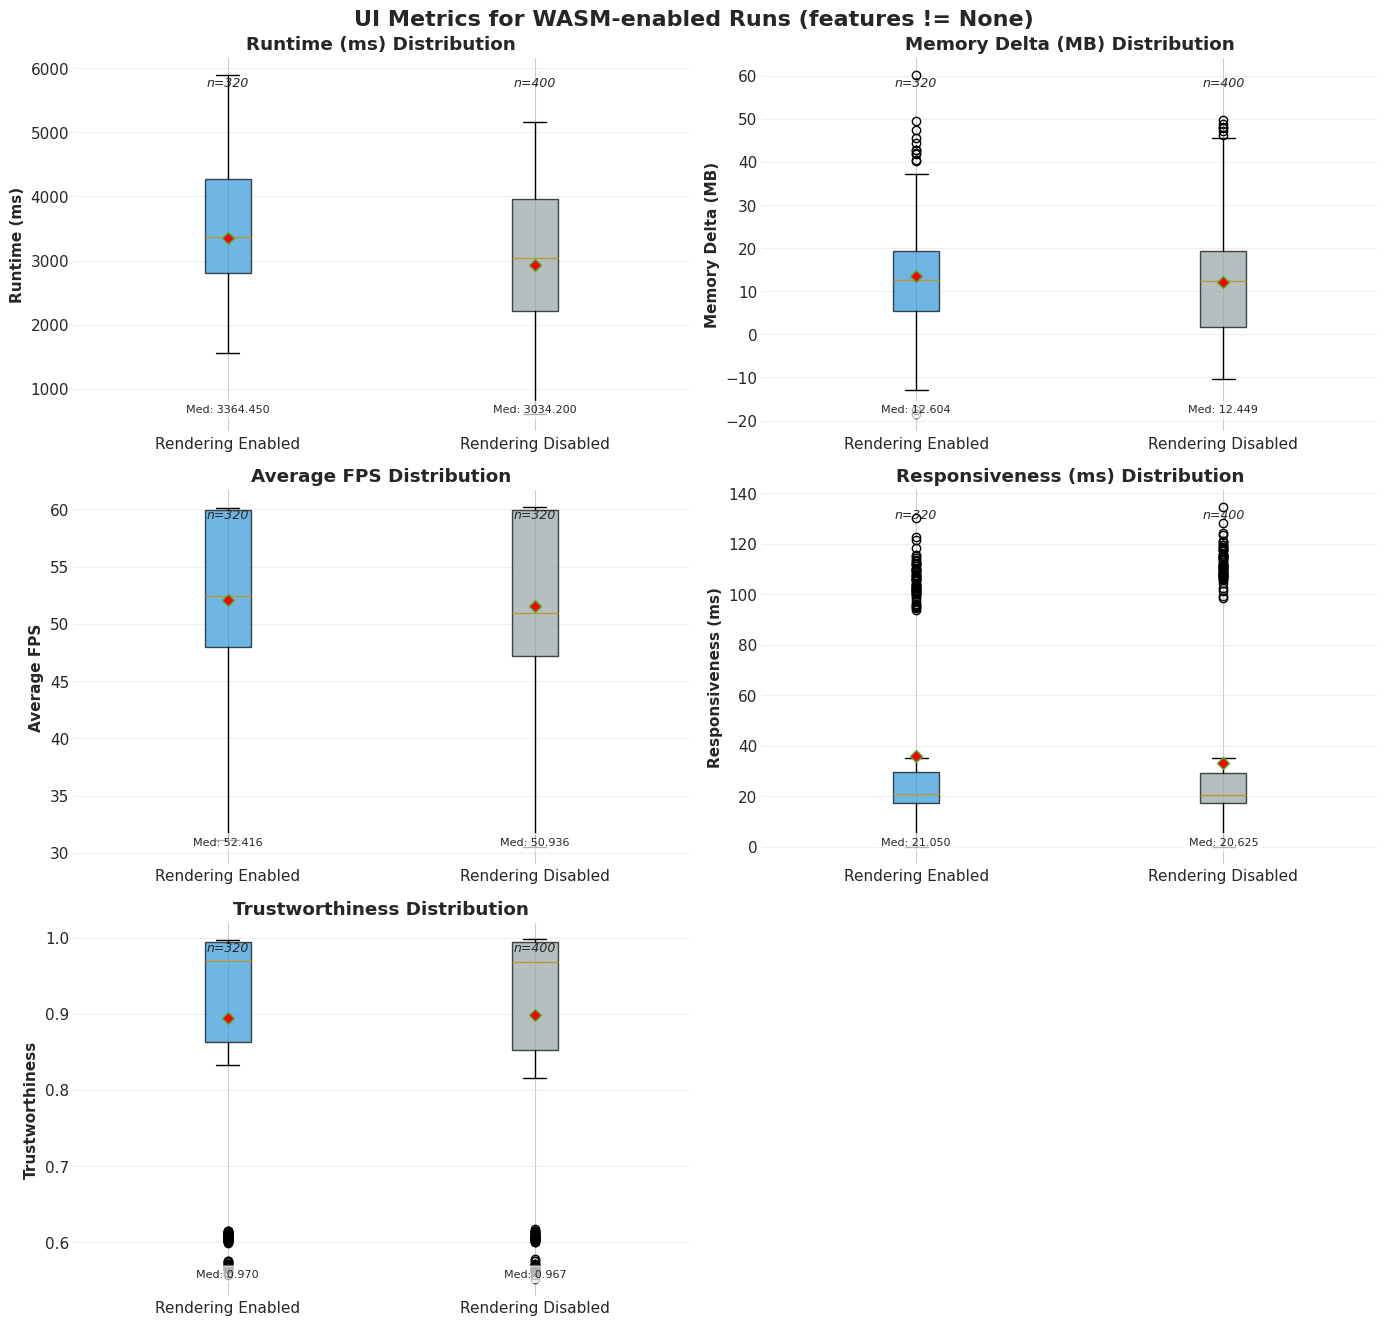


SUMMARY STATISTICS - WASM-enabled runs (features != None)
 Runtime (ms):
------------------------------------------------------------
  Rendering Enabled:
    Mean: 3350.9662, Median: 3364.4500, Std: 914.4966
    Min: 1553.4000, Max: 5896.3000
  Rendering Disabled:
    Mean: 2928.5747, Median: 3034.2000, Std: 1402.2814
    Min: 602.6000, Max: 5157.5000
  Mann-Whitney U test: p-value = 0.024545 *
 Memory Delta (MB):
------------------------------------------------------------
  Rendering Enabled:
    Mean: 13.5380, Median: 12.6044, Std: 11.7208
    Min: -18.5964, Max: 60.2157
  Rendering Disabled:
    Mean: 12.1722, Median: 12.4486, Std: 11.7706
    Min: -10.4395, Max: 49.6828
  Mann-Whitney U test: p-value = 0.033573 *
 Average FPS:
------------------------------------------------------------
  Rendering Enabled:
    Mean: 52.1170, Median: 52.4163, Std: 7.5820
    Min: 31.1436, Max: 60.1519
  Rendering Disabled:
    Mean: 41.2178, Median: 48.9856, Std: 21.8305
    Min: 0.0000, Max: 60

In [50]:
# Visualize UI metrics for WASM-enabled runs (features != None)
# Separated by rendering enabled/disabled. Includes additional metrics like trustworthiness.

# Filter for WASM-enabled (any feature except 'none')
df_wasm = df_clean[df_clean['feature'] != 'none'].copy()

print(f"WASM-enabled runs: {len(df_wasm):,}")
print(f"  With rendering: {len(df_wasm[df_wasm['rendering_enabled'] == True]):,}")
print(f"  Without rendering: {len(df_wasm[df_wasm['rendering_enabled'] == False]):,}")

# Candidate metrics to visualize (will only be plotted if present and contain data)
candidate_metrics = [
    ('runtime_ms', 'Runtime (ms)'),
    ('memory_delta_mb', 'Memory Delta (MB)'),
    ('fps_avg', 'Average FPS'),
    ('responsiveness_ms', 'Responsiveness (ms)'),
    ('trustworthiness', 'Trustworthiness')
]

# Select metrics that exist in the dataframe and have at least one non-null value
metrics_to_plot_wasm = []
for col_name, label in candidate_metrics:
    if col_name in df_wasm.columns and df_wasm[col_name].dropna().shape[0] > 0:
        metrics_to_plot_wasm.append((col_name, label))

print(f"Metrics to plot: {[m[1] for m in metrics_to_plot_wasm]}")

if len(metrics_to_plot_wasm) == 0:
    print('No UI metrics found to plot for WASM-enabled runs.')
else:
    # Determine subplot grid (2 columns)
    import math
    n = len(metrics_to_plot_wasm)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 4.5 * rows))
    fig.suptitle('UI Metrics for WASM-enabled Runs (features != None)', fontsize=16, fontweight='bold')

    # Flatten axes array for easy indexing
    if isinstance(axes, np.ndarray):
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    for idx, (metric_col, metric_label) in enumerate(metrics_to_plot_wasm):
        ax = axes_flat[idx]

        # Prepare data for plotting
        data_with_render = df_wasm[df_wasm['rendering_enabled'] == True][metric_col].dropna()
        if metric_col == 'fps_avg':
            data_with_render = data_with_render[data_with_render != 0]
        data_without_render = df_wasm[df_wasm['rendering_enabled'] == False][metric_col].dropna()
        if metric_col == 'fps_avg':
            data_without_render = data_without_render[data_without_render != 0]

        # Create box plot
        box_data = [data_with_render, data_without_render]
        box_labels = ['Rendering Enabled', 'Rendering Disabled']

        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                        showmeans=True, meanprops=dict(marker='D', markerfacecolor='red', markersize=6))

        # Color the boxes
        colors = ['#3498db', '#95a5a6']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax.set_ylabel(metric_label, fontweight='bold')
        ax.set_title(f'{metric_label} Distribution', fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        # Add sample size annotations
        ylim = ax.get_ylim()
        y_annot = ylim[1] - (ylim[1] - ylim[0]) * 0.05
        ax.text(1, y_annot, f'n={len(data_with_render)}', ha='center', va='top', fontsize=9, style='italic')
        ax.text(2, y_annot, f'n={len(data_without_render)}', ha='center', va='top', fontsize=9, style='italic')

        # Add median values as text
        if len(data_with_render) > 0:
            ax.text(1, ylim[0] + (ylim[1] - ylim[0]) * 0.05, f'Med: {data_with_render.median():.3f}',
                    ha='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        if len(data_without_render) > 0:
            ax.text(2, ylim[0] + (ylim[1] - ylim[0]) * 0.05, f'Med: {data_without_render.median():.3f}',
                    ha='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Hide any unused subplots
    for j in range(n, len(axes_flat)):
        axes_flat[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS - WASM-enabled runs (features != None)")
    print("="*80)

    for metric_col, metric_label in metrics_to_plot_wasm:
        print(f" {metric_label}:")
        print("-" * 60)

        render_data = df_wasm[df_wasm['rendering_enabled'] == True][metric_col].dropna()
        no_render_data = df_wasm[df_wasm['rendering_enabled'] == False][metric_col].dropna()

        if len(render_data) > 0:
            print(f"  Rendering Enabled:")
            print(f"    Mean: {render_data.mean():.4f}, Median: {render_data.median():.4f}, Std: {render_data.std():.4f}")
            print(f"    Min: {render_data.min():.4f}, Max: {render_data.max():.4f}")

        if len(no_render_data) > 0:
            print(f"  Rendering Disabled:")
            print(f"    Mean: {no_render_data.mean():.4f}, Median: {no_render_data.median():.4f}, Std: {no_render_data.std():.4f}")
            print(f"    Min: {no_render_data.min():.4f}, Max: {no_render_data.max():.4f}")

        # Statistical test if both groups have data
        if len(render_data) > 0 and len(no_render_data) > 0:
            stat, p_value = mannwhitneyu(render_data, no_render_data, alternative='two-sided')
            print(f"  Mann-Whitney U test: p-value = {p_value:.6f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else '(n.s.)'}")


In [51]:
# Summary table of UI metrics by dataset size (small / mid / large) for WASM-enabled runs

# Ensure we operate on WASM-enabled subset
if 'df_wasm' not in globals():
    df_wasm = df_clean[df_clean['feature'] != 'none'].copy()

# Build metrics list if needed
if 'metrics_to_plot_wasm' not in globals():
    candidate_metrics = [
        ('runtime_ms', 'Runtime (ms)'),
        ('memory_delta_mb', 'Memory Delta (MB)'),
        ('fps_avg', 'Average FPS'),
        ('responsiveness_ms', 'Responsiveness (ms)'),
        ('trustworthiness', 'Trustworthiness')
    ]
    metrics_to_plot_wasm = []
    for col_name, label in candidate_metrics:
        if col_name in df_wasm.columns and df_wasm[col_name].dropna().shape[0] > 0:
            metrics_to_plot_wasm.append((col_name, label))

metric_cols = [m[0] for m in metrics_to_plot_wasm]

# Create size buckets
labels = ['small', 'mid', 'large']
try:
    df_wasm['size_bucket'] = pd.qcut(df_wasm['dataset_size'], q=[0, 1/3, 2/3, 1], labels=labels)
except Exception:
    df_wasm['size_bucket'] = pd.cut(df_wasm['dataset_size'], bins=3, labels=labels)

# Show thresholds for transparency
size_bounds = df_wasm.groupby('size_bucket')['dataset_size'].agg(['min','max','count']).reset_index()
print("Dataset size buckets (min/max/count):")
print(size_bounds)

# Aggregate metrics by size bucket and rendering enabled
summary_wasm = (
    df_wasm
    .groupby(['size_bucket', 'rendering_enabled'])[metric_cols]
    .agg(['mean', 'median', 'std', 'min', 'max', 'count'])
    .round(3)
)

display(summary_wasm)


Dataset size buckets (min/max/count):
  size_bucket   min   max  count
0       small    80   150    240
1         mid   600   600    240
2       large  1000  1000    240


runtime_ms                                          memory_delta_mb                  \
                                    mean   median       std     min     max count            mean  median     std   
size_bucket rendering_enabled                                                                                       
small       False               1740.462  1575.75  1092.963   602.6  3554.2   160           4.810   2.546   6.870   
            True                2786.178  2669.10   439.013  2312.3  3420.6    80           6.705   5.277   6.900   
mid         False               2995.952  3026.65   745.115  1689.4  4329.6   120          15.398  16.064   8.115   
            True                2838.434  2956.75   753.922  1553.4  4272.2   120          14.910  16.484   8.052   
large       False               4445.347  4662.60   468.431  3483.8  5157.5   120          18.764  18.279  14.437   
            True                4240.024  4407.40   518.752  3043.1  5896.3   120          16.721  15.304  15.110   

                                                    fps_avg                                       responsiveness_ms  \
                                  min     max count    mean  median     std     min     max count              mean   
size_bucket rendering_enabled                                                                                         
small       False              -7.679  29.001   160  26.946  21.149  27.389   0.000  60.028   160            14.457   
            True               -8.420  33.154    80  54.082  55.078   6.016  44.987  60.093    80            14.314   
mid         False             -10.440  36.462   120  52.983  52.997   5.628  42.536  60.087   120            20.330   
            True              -10.345  30.379   120  53.519  53.995   5.956  38.142  60.099   120            18.643   
large       False              -8.344  49.683   120  48.481  49.220   9.862  30.533  60.193   120            71.601   
            True              -18.596  60.216   120  49.405  50.244   9.089  31.144  60.152   120            67.444   

                                                                     trustworthiness                                    
                               median     std     min      max count            mean median    std    min    max count  
size_bucket rendering_enabled                                                                                           
small       False              14.463   6.194   0.000   24.980   160           0.919  0.933  0.069  0.815  0.991   160  
            True               15.108   7.022   0.000   24.993    80           0.926  0.938  0.064  0.833  0.991    80  
mid         False              20.147   2.884  14.718   30.480   120           0.972  0.973  0.022  0.945  0.995   120  
            True               18.241   2.795  13.209   31.020   120           0.972  0.973  0.022  0.945  0.995   120  
large       False              67.013  41.692  26.027  134.591   120           0.796  0.807  0.203  0.552  0.997   120  
            True               64.550  39.274  24.687  130.155   120           0.796  0.806  0.203  0.558  0.997   120

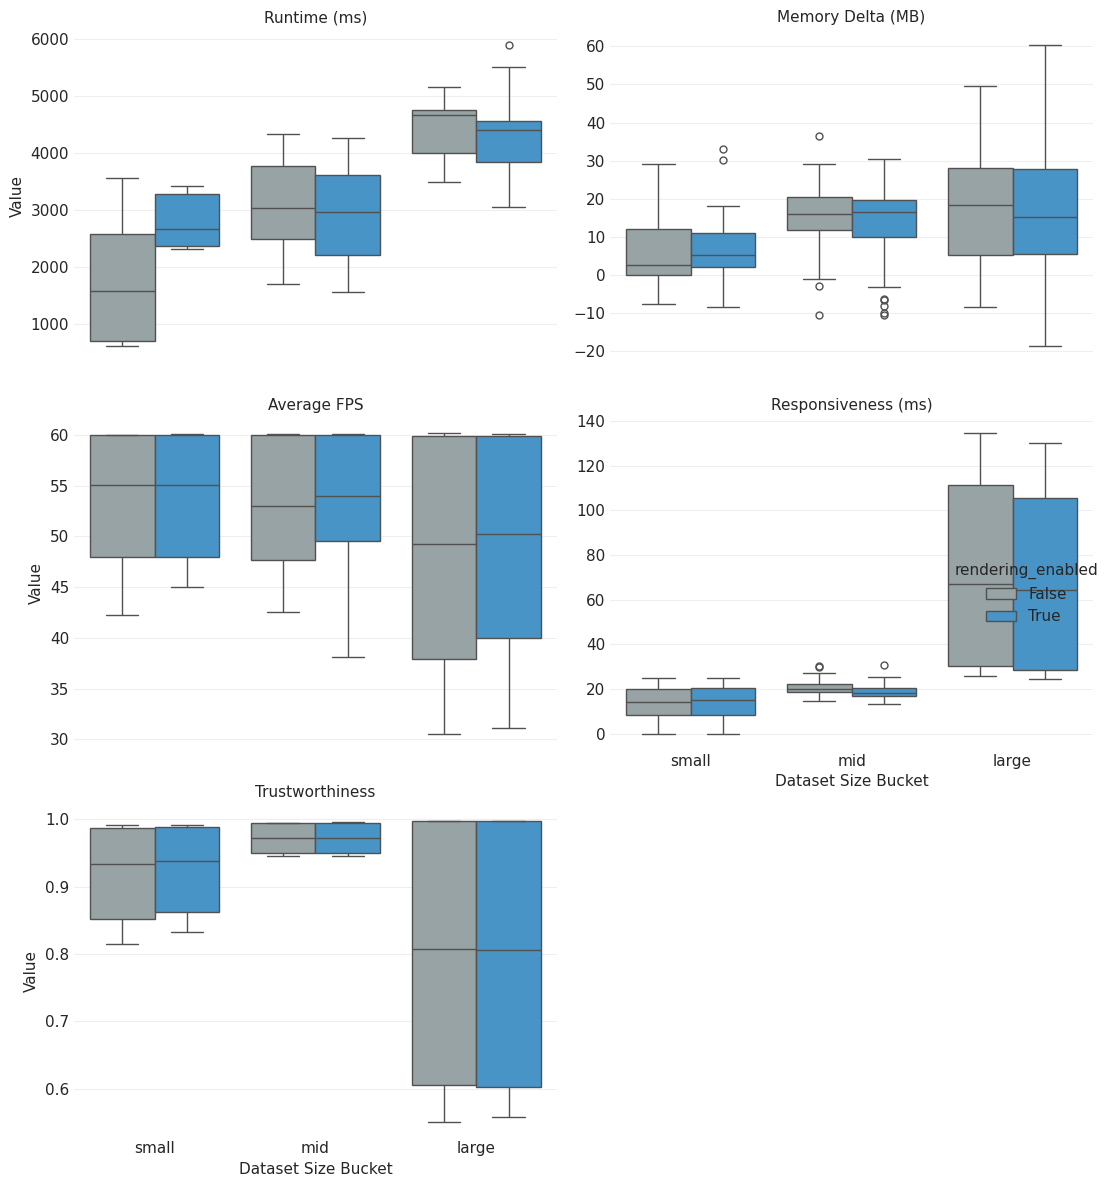

In [52]:
# Visualize UI metrics by dataset size bucket and rendering state (WASM-enabled)

# Prepare long-form data
plot_df = df_wasm.copy()

# Ensure size_bucket exists
if 'size_bucket' not in plot_df.columns:
    labels = ['small', 'mid', 'large']
    try:
        plot_df['size_bucket'] = pd.qcut(plot_df['dataset_size'], q=[0, 1/3, 2/3, 1], labels=labels)
    except Exception:
        plot_df['size_bucket'] = pd.cut(plot_df['dataset_size'], bins=3, labels=labels)

metric_cols = [m[0] for m in metrics_to_plot_wasm]
metric_label_map = dict(metrics_to_plot_wasm)

long_df = plot_df.melt(
    id_vars=['size_bucket', 'rendering_enabled'],
    value_vars=metric_cols,
    var_name='metric',
    value_name='value'
)
long_df = long_df.dropna(subset=['value'])
# Exclude zero/negative FPS values from plots
long_df.loc[long_df['metric'] == 'fps_avg', 'value'] = pd.to_numeric(
    long_df.loc[long_df['metric'] == 'fps_avg', 'value'], errors='coerce'
)
long_df = long_df[~((long_df['metric'] == 'fps_avg') & (long_df['value'] <= 0))]
long_df['metric_label'] = long_df['metric'].map(metric_label_map)

# Faceted boxplots
sns.set_style('whitegrid')
g = sns.catplot(
    data=long_df,
    x='size_bucket',
    y='value',
    hue='rendering_enabled',
    col='metric_label',
    kind='box',
    col_wrap=2,
    sharey=False,
    height=4,
    aspect=1.2,
    palette={True: '#3498db', False: '#95a5a6'}
)

g.set_titles('{col_name}')
g.set_axis_labels('Dataset Size Bucket', 'Value')
for ax in g.axes.flat:
    ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
